In [1]:
# %load robust-pca/r_pca.py
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100, verbose=True):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if verbose and ((iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol):
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


In [2]:
def values(func, left, right, n):
    return func(np.linspace(left, right, n))

def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

In [3]:
def wtt_rpca(
    input_vector,
    d,
    modes,
    ranks=None,
    eps=None,
    lambda_scale=1.0,
    verbose=True,
    check_correctness=False
):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        
        #делаем разложение A = L + S, L --- малоранговая, S --- разреженная
        #затем: L = U Sigma V^T --- SVD для L. Ненулевых сингулярных чисел будет мало (надеемся)
        #U^T A = Sigma V^T + U^T S. Старшие строки оставляем для дальнейшей работы.
        #Надеемся, что младшие строки U^T S тоже будут разреженными...
        
        rpca = R_pca(A) 
        
        rpca.lmbda = rpca.lmbda * lambda_scale #делаю уклон в сторону sparse'овости
        
        if verbose:
            print("Step", k, "out of", d)
        
        L, S = rpca.fit(
            max_iter=4000,
            iter_print=400,
            verbose=verbose
        )
        
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)
        
        if verbose:
            
            print(
                "Low-rank check:",
                "r_cur = ", r_cur,
                "\n#singular values = ", sigmas.size,
                "\n#nnz singlular values = ", (sigmas > 1e-10).sum(),
                sep=''
            )

            print(
                "Sparsity check:",
                "S.size = ", S.size,
                "\nnnz(S) = ", np.count_nonzero(S), #можно так, поскольку S-часть по-честному разреженная
                "\nnnz(u.T @ S) = ", np.count_nonzero(u.T @ S),
                sep=''
            )

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            #A = (u.T @ (L + S))[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

In [4]:
import scipy.sparse

In [5]:
test = np.array([
    [0,1,0,2,0],
    [0,3,0,0,0],
    [4,0,0,0,3]
])
test_s = scipy.sparse.csr_matrix(test)
print(test_s)

  (0, 1)	1
  (0, 3)	2
  (1, 1)	3
  (2, 0)	4
  (2, 4)	3


In [6]:
test_2 = np.ones(test.shape, dtype=test.dtype)
np.asarray(test_2 + test_s)

array([[1, 2, 1, 3, 1],
       [1, 4, 1, 1, 1],
       [5, 1, 1, 1, 4]])

Попробуем сохранять sparse-части и отдельно их вычитать.

In [7]:
def wtt_rpca_v2(
    input_vector,
    d,
    modes,
    ranks=None,
    eps=None,
    lambda_scale=1.0,
    verbose=True,
    check_correctness=False
):
    assert ranks is not None or eps is not None
    
    filters = []
    sparse_parts = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        
        #делаем разложение A = L + S, L --- малоранговая, S --- разреженная
        #затем: L = U Sigma V^T --- SVD для L. Ненулевых сингулярных чисел будет мало (надеемся)
        #U^T A = Sigma V^T + U^T S. Старшие строки оставляем для дальнейшей работы.
        #Надеемся, что младшие строки U^T S тоже будут разреженными...
        
        rpca = R_pca(A) 
        
        rpca.lmbda = rpca.lmbda * lambda_scale #делаю уклон в сторону sparse'овости
        
        if verbose:
            print("Step", k, "out of", d)
        
        L, S = rpca.fit(
            max_iter=4000,
            iter_print=400,
            verbose=verbose
        )
        
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)
        sparse_parts.append(scipy.sparse.csr_matrix(S))
        #скорее всего, строк меньше, чем столбцов, так что csr
        
        if verbose:
            print(
                "Low-rank check:",
                "r_cur = ", r_cur,
                "\n#singular values = ", sigmas.size,
                "\n#nnz singlular values = ", (sigmas > 1e-10).sum(),
                sep=''
            )
            print(
                "Sparsity check:",
                "S.size = ", S.size,
                "\nnnz(S) = ", np.count_nonzero(S), #можно так, поскольку S-часть по-честному разреженная
                #"\nnnz(u.T @ S) = ", np.count_nonzero(u.T @ S),
                sep=''
            )

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ L)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, sparse_parts, true_ranks

Теперь нужен новый алгоритм для применения:

In [8]:
def wtt_apply_rpca(input_vector, d, filters, sparse_parts, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(sparse_parts) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = np.asarray(A - sparse_parts[k])
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [9]:
def iwtt_apply_rpca(input_vector, d, filters, sparse_parts, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(sparse_parts) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result)
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ]))
        result = np.asarray(result + sparse_parts[k])
        result = result.reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [10]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

signal = values(lambda x: np.cos(100 * x ** 2) - np.sin(150 * x ** 2), left, right, n)

modes = [2] * d
ranks_est = [4] * (d - 1)

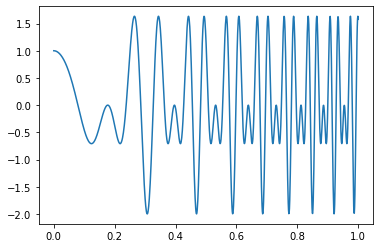

In [11]:
plt.plot(linspace, signal)

In [12]:
ranks_est = [25] * (d - 1)
eps = 1e-10

filters, ranks = wtt_filter(
    signal,
    d,
    modes,
    ranks=ranks_est,
    eps=eps,
    check_correctness=True
)
wtt_res = wtt_apply(
    signal,
    d,
    filters,
    modes,
    ranks,
    True
)
print(ranks)

[2, 4, 8, 11, 14, 16, 8, 4, 2]


In [13]:
filters_rpca, ranks_rpca = wtt_rpca(
    signal,
    d,
    modes,
    ranks=ranks_est,
    eps=eps,
    lambda_scale=1,
    verbose=False,
    check_correctness=True
)
wtt_res_rpca_1 = wtt_apply(
    signal,
    d,
    filters_rpca,
    modes,
    ranks_rpca,
    True
)
print(ranks_rpca)

[1, 1, 1, 1, 1, 1, 2, 2, 2]


In [14]:
filters_rpca_2, sparse_parts, ranks_rpca_2 = wtt_rpca_v2(
    signal,
    d,
    modes,
    ranks=ranks_est,
    eps=eps,
    lambda_scale=1, #уже необязательно увеличивать
    verbose=False,
    check_correctness=True
)
wtt_res_rpca_2 = wtt_apply_rpca(
    signal,
    d,
    filters_rpca_2,
    sparse_parts,
    modes,
    ranks_rpca_2,
    True
)
print(ranks_rpca_2)

[1, 1, 1, 1, 1, 2, 1, 2, 2]


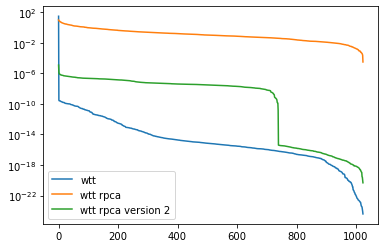

In [15]:
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res))), label='wtt')
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res_rpca_1))), label='wtt rpca')
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res_rpca_2))), label='wtt rpca version 2')
plt.yscale('log')
plt.legend()
plt.show()

In [16]:
iwtt_res = iwtt_apply_rpca(
    wtt_res_rpca_2,
    d,
    filters_rpca_2,
    sparse_parts,
    modes,
    ranks_rpca_2,
    True
)
np.linalg.norm(signal - iwtt_res)

8.008828117763436e-15

In [17]:
print(wtt_res_rpca_2)

[ 1.19640923e-05 -5.06529117e-08 -6.49128454e-10 ... -1.56616890e-16
 -2.48389908e-16  7.59452305e-17]


Внезапно теперь все коэффициенты относительно маленькие (однако убывание, увы, не может догнать обычное WTT с аналогичными параметрами $\varepsilon$ и рангами).

In [18]:
iwtt_res_2 = iwtt_apply_rpca(
    np.zeros(wtt_res_rpca_2.size),
    d,
    filters_rpca_2,
    sparse_parts,
    modes,
    ranks_rpca_2,
    True
)
np.linalg.norm(signal - iwtt_res_2)

1.2850986583449228e-05

Посчитаем затраты памяти:

In [19]:
memcells_1 = 0
for u in filters_rpca_2:
    memcells_1 += u.size
memcells_2 = 0
for u in sparse_parts:
    memcells_2 += u.data.size
print(memcells_1, memcells_2)

76 1491


In [20]:
memcells_classic = 0
for u in filters:
    memcells_classic += u.size
print(memcells_classic)

2968


Теперь будем перебирать $\lambda$ и считать затраты памяти.

In [33]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

signal = values(lambda x: np.cos(100 * x ** 2) - np.sin(150 * x ** 2), left, right, n)

modes = [2] * d
ranks_est = [25] * (d - 1)
eps = 1e-12

In [37]:
scales = np.linspace(1, 5, 40)
memory_wtt_rpca_1 = []
memory_wtt_rpca_2 = []

comp_ratios_rpca_1 = []
comp_ratios_rpca_2 = []

delta = 1e-10

filters, ranks = wtt_filter(
    signal,
    d,
    modes,
    ranks=ranks_est,
    eps=eps,
    check_correctness=True
)
wtt_res = wtt_apply(
    signal,
    d,
    filters,
    modes,
    ranks,
    True
)

memory_wtt = 0
for u in filters:
    memory_wtt += u.size

comp_ratio_wtt = (np.abs(wtt_res) < delta).sum() / wtt_res.size
#чем выше к 1, тем лучше

for s in scales:    
    filters_rpca, ranks_rpca = wtt_rpca(
        signal,
        d,
        modes,
        ranks=ranks_est,
        eps=eps,
        lambda_scale=s,
        verbose=False,
        check_correctness=True
    )
    wtt_res_rpca_1 = wtt_apply(
        signal,
        d,
        filters_rpca,
        modes,
        ranks_rpca,
        True
    )
    
    memcells_1 = 0
    for u in filters_rpca_2:
        memcells_1 += u.size
    memory_wtt_rpca_1.append(memcells_1)
    
    ratio = (np.abs(wtt_res_rpca_1) < delta).sum() / wtt_res_rpca_1.size
    comp_ratios_rpca_1.append(ratio)
    
    filters_rpca_2, sparse_parts, ranks_rpca_2 = wtt_rpca_v2(
        signal,
        d,
        modes,
        ranks=ranks_est,
        eps=eps,
        lambda_scale=s,
        verbose=False,
        check_correctness=True
    )
    wtt_res_rpca_2 = wtt_apply_rpca(
        signal,
        d,
        filters_rpca_2,
        sparse_parts,
        modes,
        ranks_rpca_2,
        True
    )
    
    memcells_1 = 0
    for u in filters_rpca_2:
        memcells_1 += u.size
    memcells_2 = 0
    for u in sparse_parts:
        memcells_2 += u.data.size
    memory_wtt_rpca_2.append(memcells_1 + memcells_2)
    
    ratio = (np.abs(wtt_res_rpca_2) < delta).sum() / wtt_res_rpca_2.size
    comp_ratios_rpca_2.append(ratio)

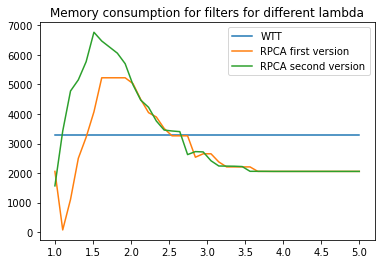

In [38]:
plt.plot(scales, np.full(scales.shape, memory_wtt), label='WTT')
plt.plot(scales, np.full(scales.shape, memory_wtt_rpca_1), label='RPCA first version')
plt.plot(scales, np.full(scales.shape, memory_wtt_rpca_2), label='RPCA second version')
plt.title("Memory consumption for filters for different lambda")
plt.legend()
plt.show()

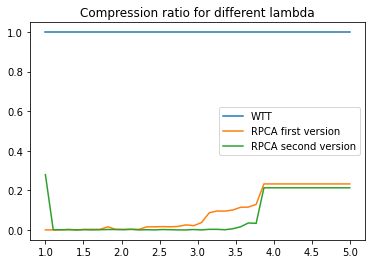

In [39]:
plt.plot(scales, np.full(scales.shape, comp_ratio_wtt), label='WTT')
plt.plot(scales, np.full(scales.shape, comp_ratios_rpca_1), label='RPCA first version')
plt.plot(scales, np.full(scales.shape, comp_ratios_rpca_2), label='RPCA second version')
plt.title("Compression ratio for different lambda")
plt.legend()
plt.show()